<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/8/lab.ipynb">link</a>

Authorize google + kaggle

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Be sure, that we authorized and have an access to kaggle

In [2]:
%ls /content/.kaggle/

kaggle.json*


# **Part 1: Download dataset, display, load, capture metrics**

Download dataset:

In [3]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download robervalt/sunspots -p robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 19.8MB/s]


Extract .zip:

In [4]:
!unzip robervalt/sunspots/sunspots.zip -d data

Archive:  robervalt/sunspots/sunspots.zip
  inflating: data/Sunspots.csv       


Load data:

In [5]:
import pandas as pd

DATA_PATH = './data/Sunspots.csv'
VALUES = 'Monthly Mean Total Sunspot Number'

def get_dataset():
  df = pd.read_csv(DATA_PATH)
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  return df

df = get_dataset()

df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Visualize it via timeline chart:

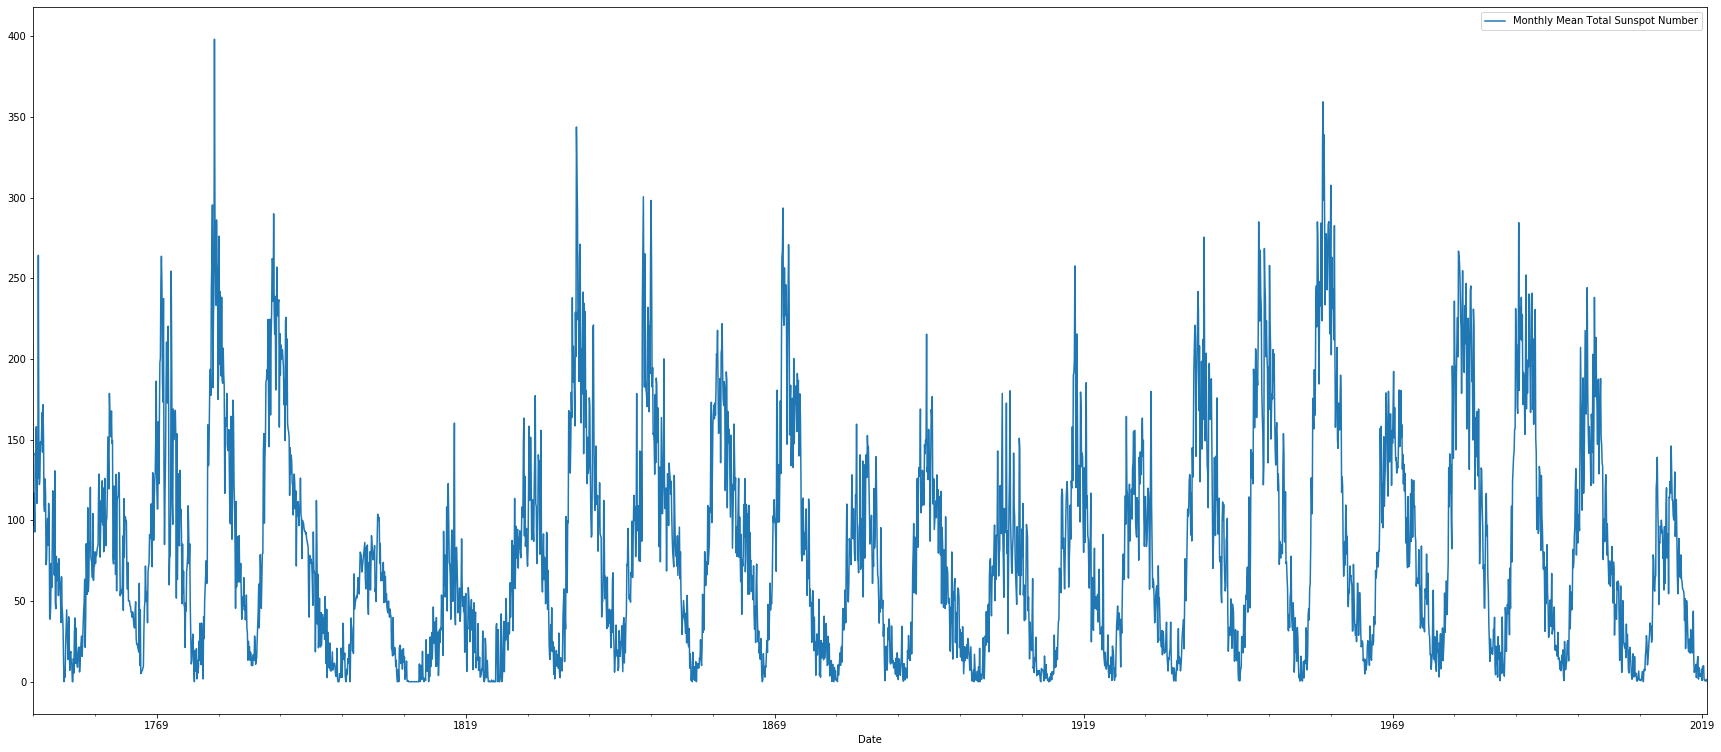

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

df_plot = get_dataset()

df_plot['Date']= pd.to_datetime(df_plot['Date'])

df_plot.plot(x = 'Date', y = VALUES)

Capture *seasonality, trend, autocorrelation*:

In [18]:
# autocorrelation
from pandas.plotting import autocorrelation_plot
plt.rcParams['figure.figsize'] = [170, 130]

series = get_dataset()
autocorrelation_plot(series[VALUES])
plt.show()

p~6

<Figure size 2160x936 with 0 Axes>

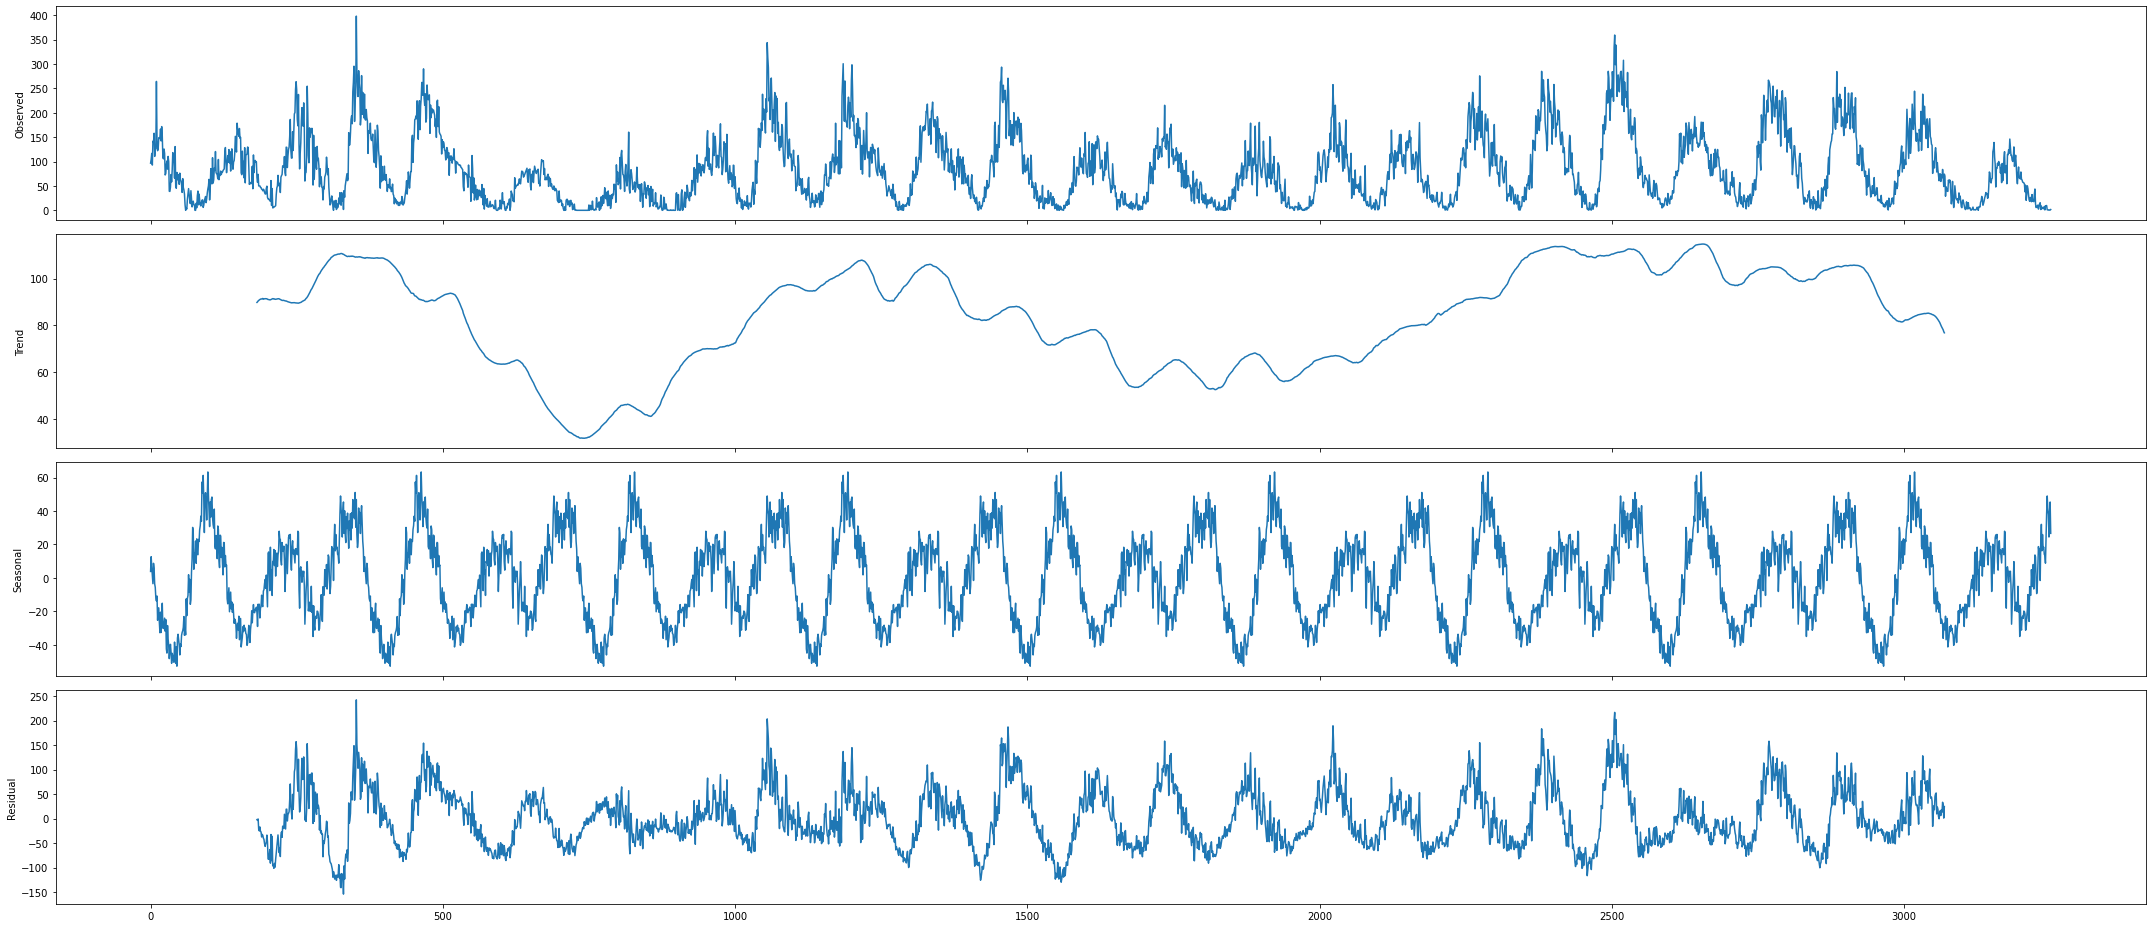

In [8]:
# trend
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

from statsmodels.tsa.seasonal import seasonal_decompose

series = get_dataset()

result = seasonal_decompose(series[VALUES], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()
fig.show()

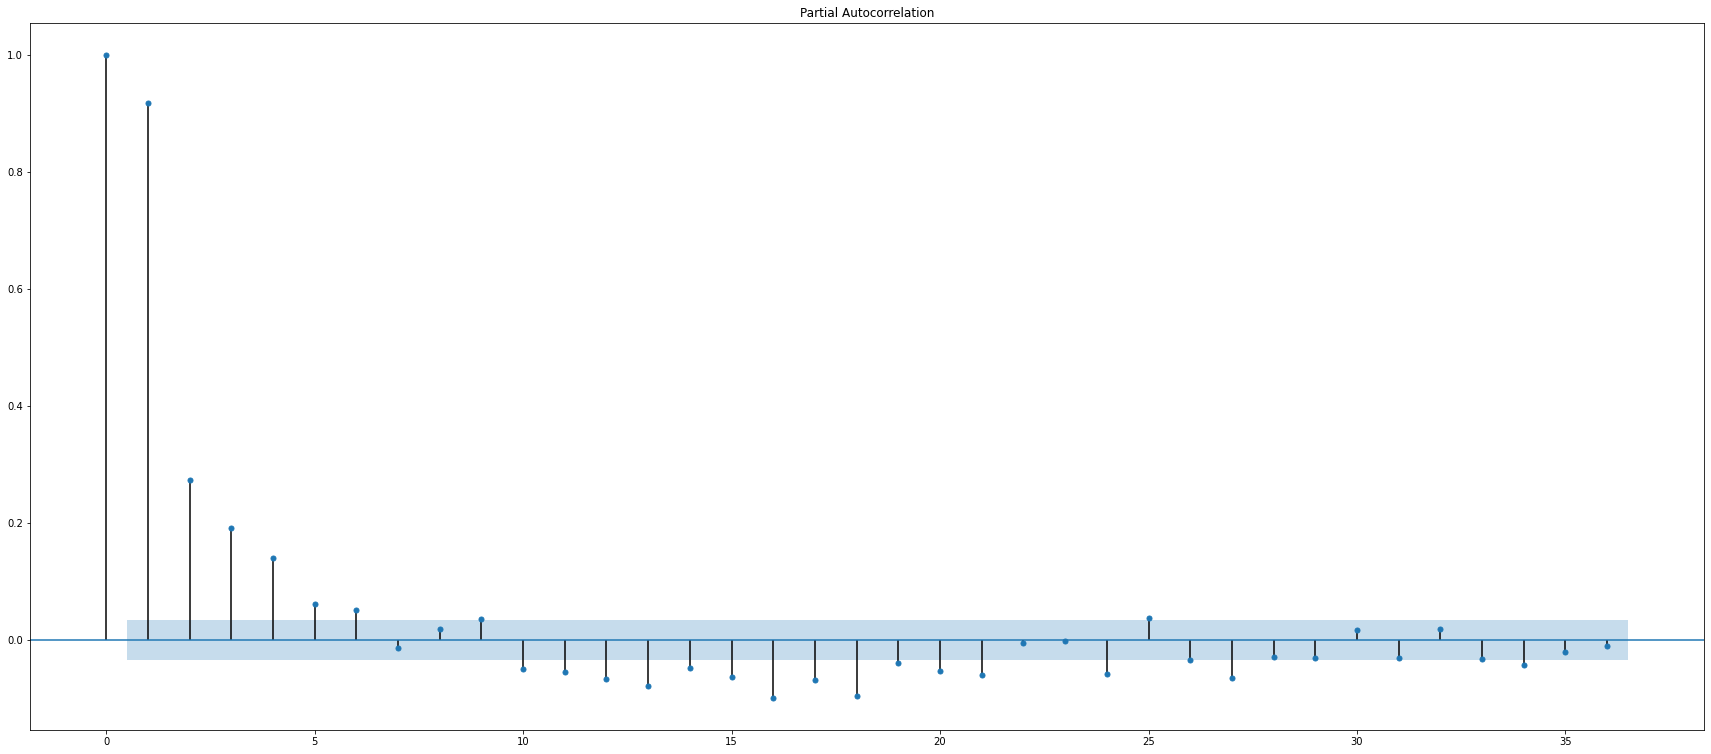

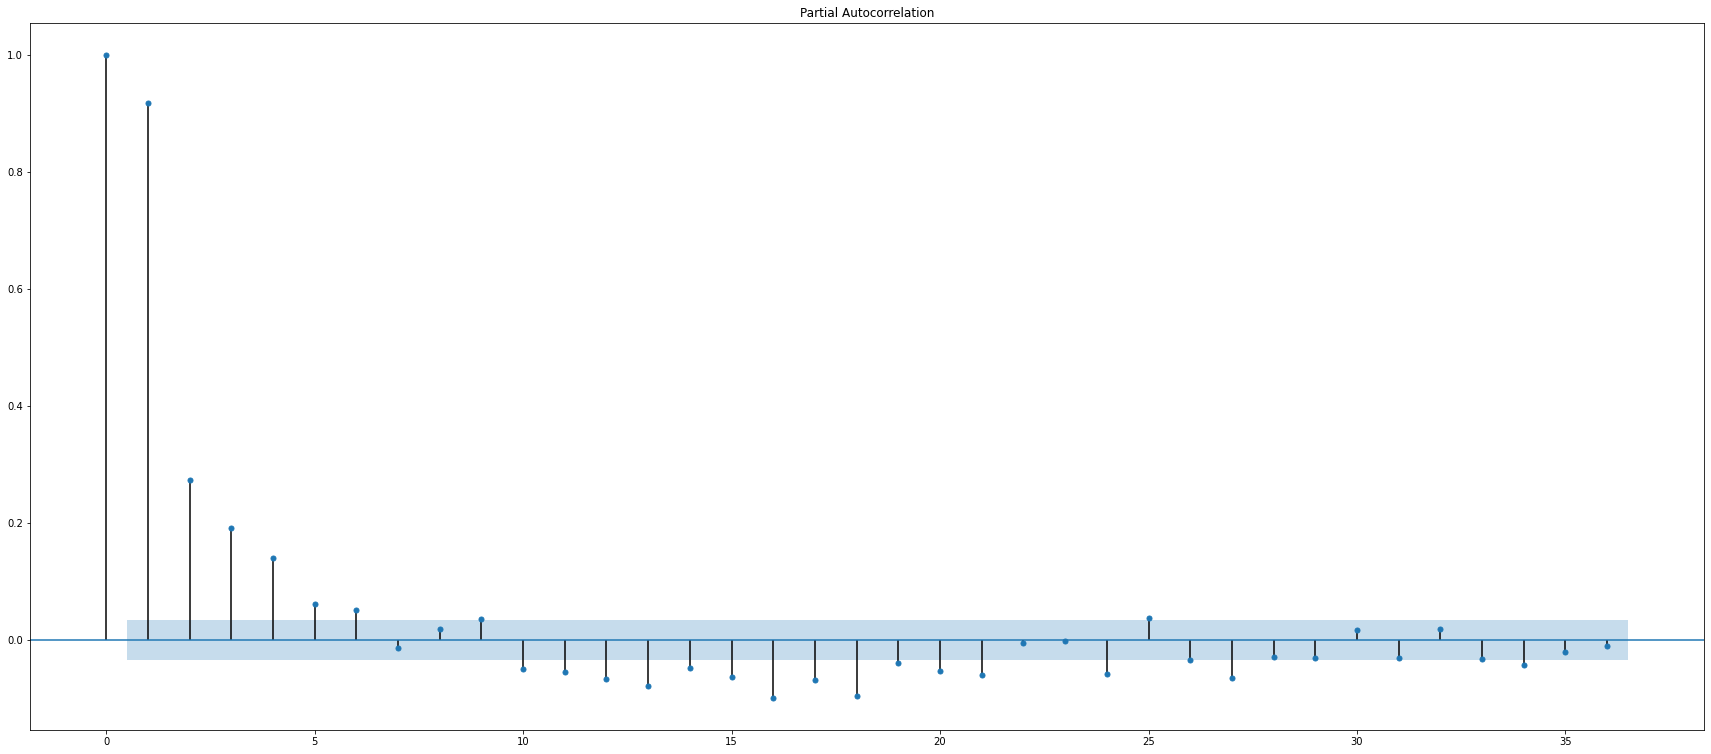

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(series[VALUES])

q~1 (blue area)

# **Part 2: dataset splitting**

Use first 70% as train-data, and other 30% as test:

In [0]:
def ts_split(data,percentage=0.7):
    n = int(data.shape[0]*percentage)
    return data[:n], data[n+1:]

train, test = ts_split(df)

# **Part 3: ARIMA as a prediction model**

In [24]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# TODO: describe how 3,0,2 params were choosen
arima = ARIMA(train[VALUES], (6,0,1), dates=train['Date']).fit()

steps = len(test)
start_index = len(train)
end_index = start_index + steps
# predictions = arima.predict(start=start_index, end=end_index)
predictions = arima.forecast(steps=steps)[0]

# print summary of fit model
print(arima.summary())

# ---TODO---
# RMSE
# RAE
# Charts

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                      ARMA Model Results                                     
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2276
Model:                                    ARMA(6, 1)   Log Likelihood              -10576.563
Method:                                      css-mle   S.D. of innovations             25.219
Date:                               Sat, 04 Apr 2020   AIC                          21171.127
Time:                                       20:32:07   BIC                          21222.699
Sample:                                   01-31-1749   HQIC                         21189.939
                                        - 08-31-1938                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

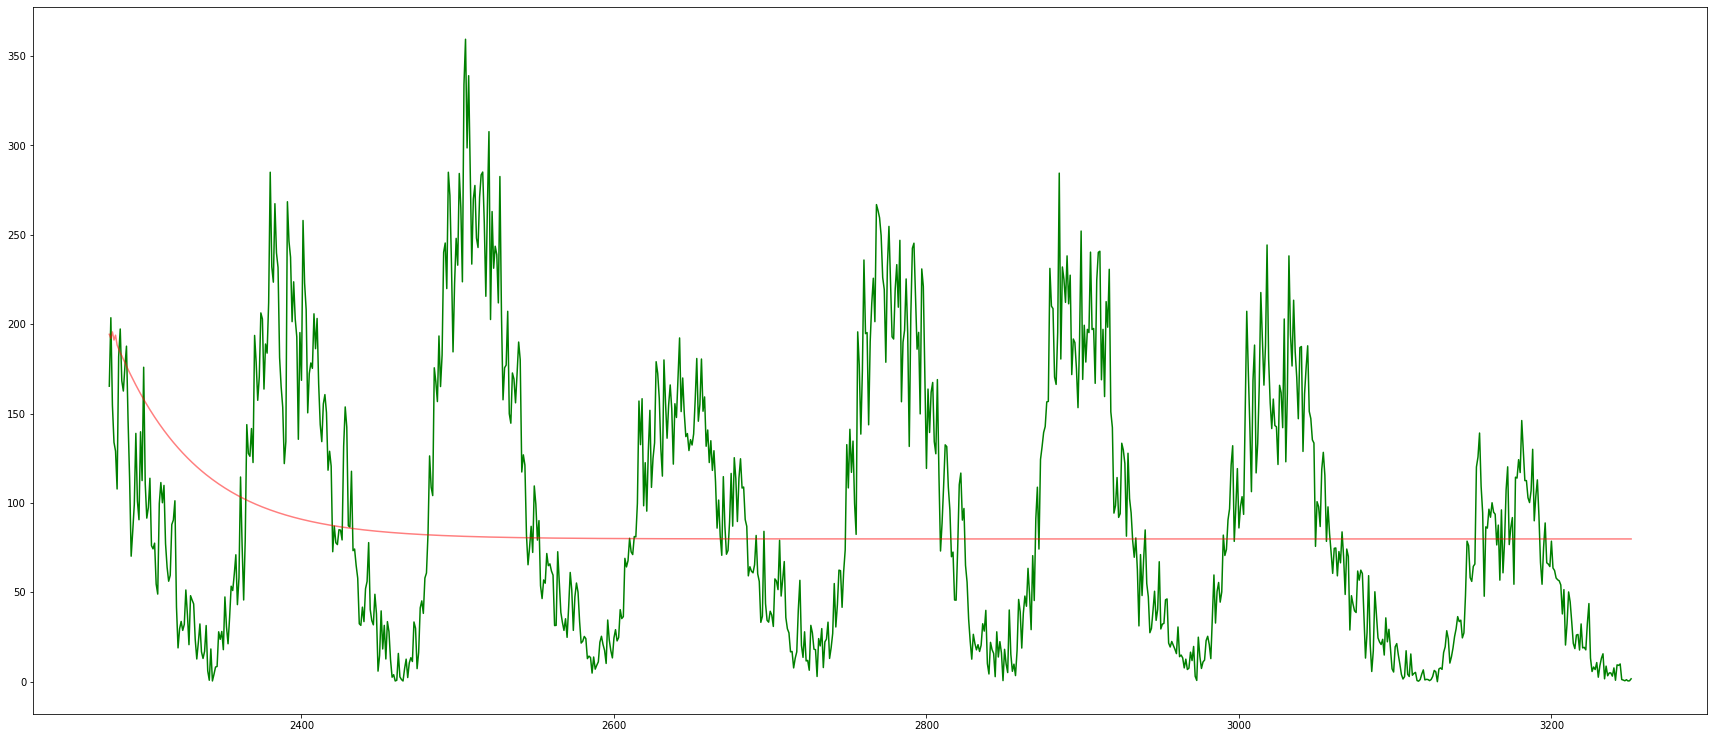

In [25]:
plt.rcParams['figure.figsize'] = [30, 13]

def predictions_to_test(predictions):
    train, test = ts_split(get_dataset())
    test[VALUES] = predictions

    return test

prd = predictions_to_test(predictions)

plt.plot(test[VALUES], color='green')
plt.plot(prd[VALUES], color='red', alpha=0.5)

plt.show()

# **Part 4: RNN as a prediction model**

Convert time-series to sequence->value format

In [0]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

NN model

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_features = 1
# choose a number of time steps
n_steps = 14

model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.save_weights('model.h5')

Using TensorFlow backend.


Data preprocessing

In [0]:
ds = get_dataset()
train, test = ts_split(ds)

# split into samples
X, y = split_sequence(train[VALUES], n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

Train

In [0]:
# reset weights
model.load_weights('model.h5')
# fit model
model.fit(X, y, epochs=30, verbose=1)
# demonstrate prediction
x_input = X[0]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y[0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
2262/2262 [==============================] - 3s 1ms/step - loss: 2950.0126
Epoch 2/30
2262/2262 [==============================] - 2s 804us/step - loss: 1031.4505
Epoch 3/30
2262/2262 [==============================] - 2s 937us/step - loss: 890.1907
Epoch 4/30
2262/2262 [==============================] - 3s 1ms/step - loss: 874.9759
Epoch 5/30
2262/2262 [==============================] - 2s 1ms/step - loss: 1159.7160
Epoch 6/30
2262/2262 [==============================] - 2s 1ms/step - loss: 929.0588
Epoch 7/30
2262/2262 [==============================] - 3s 1ms/step - loss: 920.6651
Epoch 8/30
2262/2262 [==============================] - 2s 941us/step - loss: 874.9252
Epoch 9/30
2262/2262 [==============================] - 2s 941us/step - loss: 772.2422
Epoch 10/30
2262/2262 [==============================] - 2s 935us/step - loss: 903.3297
Epoch 11/30
2262/2262 [=================

Prediction

In [0]:
import numpy as np

def predict(last_n_steps, replaceable):
    dfc = pd.DataFrame([], columns=('Date', VALUES))
    last_values = last_n_steps.to_numpy()
    n = replaceable.first_valid_index()
    for index, row in replaceable.iterrows():
        cp = row[VALUES]
        row[VALUES] = model.predict(last_values.reshape((1, n_steps, n_features)), verbose=0)[0][0]
        last_values = np.append(last_values, [cp])[-n_steps:]
        dfc = dfc.append(row)
    
    return dfc

predictions = predict(train[VALUES][:n_steps], test)

Draw a chart:

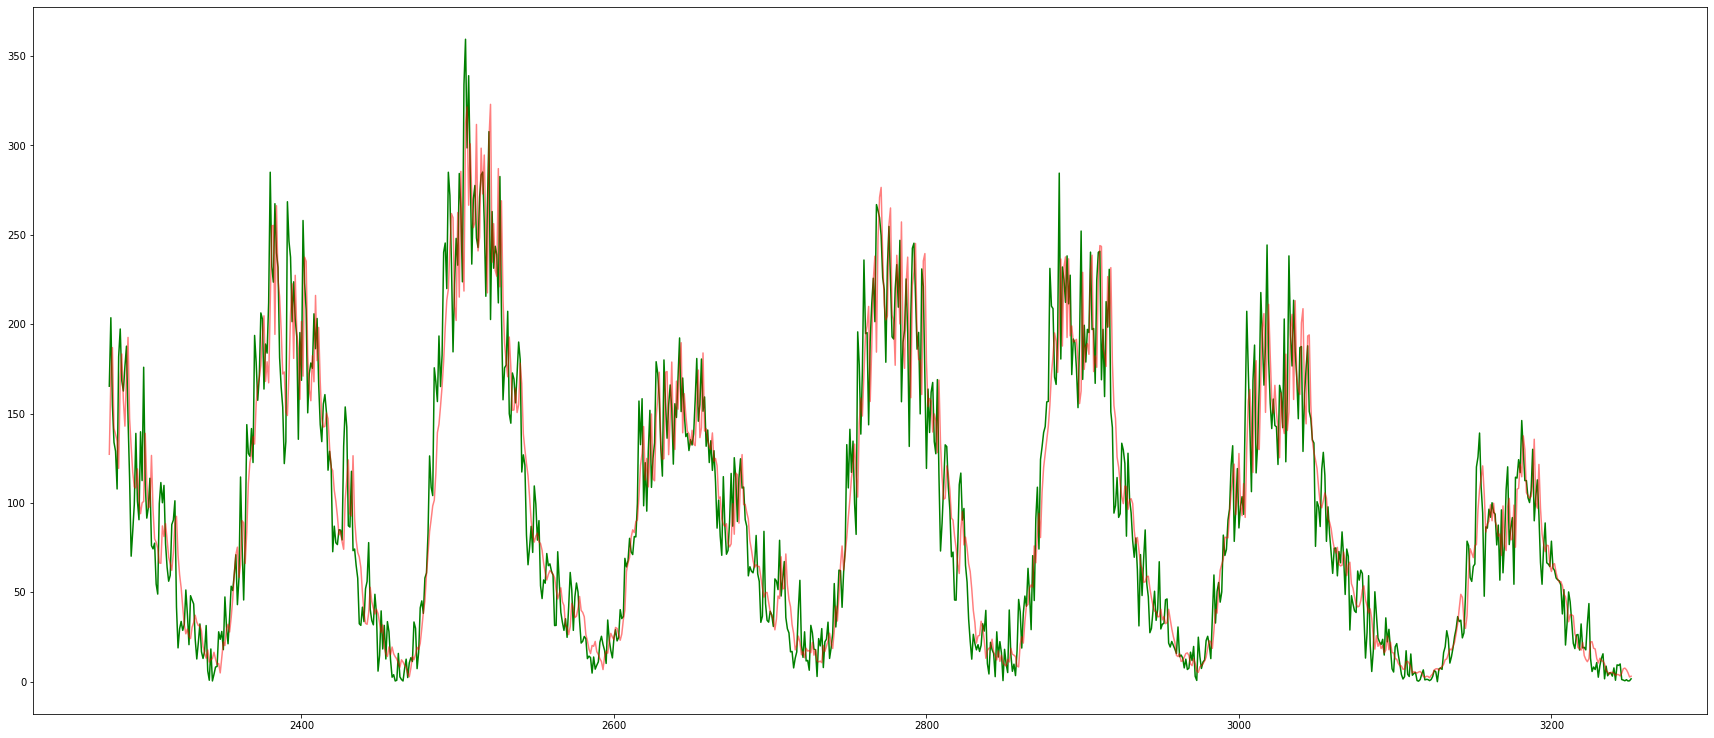

In [0]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 13]

train, test = ts_split(ds)

plt.plot(test[VALUES], color='green')
plt.plot(predictions[VALUES], color='red', alpha=0.5)

plt.show()

# **Part 5: final notes**